# Dimensionality reduction - UCSD NGP Hands-on workshop

## Tutorial 3: Dimensionality Reduction on real datasets
### Adapted from Neuromatch Academy 2020: Week 1, Day 5, Tutorial 3 and BIPN162

Content creators: Ashley Juavinett, Gal Mishne

# Tutorial Objectives
In the previous tutorial we applied PCA for **Dimensionality reduction** on a simulated dataset. In this notebook we'll run PCA on real neural data.
We'll also learn how to use PCA for reconstruction and apply logistic regression to our new data representation.

Overview:
- Perform PCA on two electrophysiology time series dataset
- Plot the results of your dimensionality reduction coloring each point by a known feature 
- Reconstruct data from PCA
- Use dimensionality reduction as a preprocessing step for Logistic regression 

---
# Setup
Run these cells to get the tutorial started.

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy.io
from collections import defaultdict
import scipy.stats as sc
%matplotlib inline
import pandas as pd
import seaborn as sns # This is another plotting package, built really nicely for plotting these types of analyses!

In [ ]:
#@title Helper Functions

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def plot_model_selection(C_values, accuracies):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.plot(C_values, accuracies, marker="o")
  best_C = C_values[np.argmax(accuracies)]
  ax.set(
      xticks=C_values,
      xlabel="$C$",
      ylabel="Cross-validated accuracy",
      title=f"Best C: {best_C:1g} ({np.max(accuracies):.2%})",
  )

def get_variance_explained(evals):
  """
  Calculates variance explained from the eigenvalues.

  Args:
    evals (numpy array of floats) : Vector of eigenvalues

  Returns:
    (numpy array of floats)       : Vector of variance explained

  """

  # cumulatively sum the eigenvalues
  csum = np.cumsum(evals)
  # normalize by the sum of eigenvalues
  variance_explained = csum / np.sum(evals)

  return variance_explained

def plot_data(X):
  """
  Plots bivariate data. Includes a plot of each random variable, and a scatter
  scatter plot of their joint activity. The title indicates the sample
  correlation calculated from the data.

  Args:
    X (numpy array of floats) : PCA matrix each column corresponds to a
                                different principal component 

  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=[8, 4])
  gs = fig.add_gridspec(2, 2)
  ax1 = fig.add_subplot(gs[0, 0])
  ax1.plot(X[:, 0], color='k')
  plt.ylabel('vector 1')
  ax2 = fig.add_subplot(gs[1, 0])
  ax2.plot(X[:, 1], color='k')
  #plt.xlabel('Sample Number (sorted)')
  plt.ylabel('vector 2')
  ax3 = fig.add_subplot(gs[:, 1])
  ax3.plot(X[:, 0], X[:, 1], '.', markerfacecolor=[.5, .5, .5],
           markeredgewidth=0)
  ax3.axis('equal')
  plt.xlabel('PCA 1')
  plt.ylabel('PCA 2')
  plt.title('Sample corr: {:.1f}'.format(np.corrcoef(X[:, 0], X[:, 1])[0, 1]))
  plt.show()

    
def plot_variance_explained(variance_explained):
  """
  Plots eigenvalues.

  Args:
    variance_explained (numpy array of floats) : Vector of variance explained
                                                 for each PC

  Returns:
    Nothing.

  """

  plt.figure()
  plt.plot(np.arange(1, len(variance_explained) + 1), variance_explained,
           'k')
  plt.xlabel('Number of components')
  plt.ylabel('Variance explained')
  plt.axhline(.9,c='r',ls='--')
  plt.show()


def change_of_basis(X, W):
  """
  Projects data onto a new basis.

  Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

  Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
  """

  Y = np.matmul(X, W)

  return Y


def get_sample_cov_matrix(X):
  """
  Returns the sample covariance matrix of data X.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    (numpy array of floats)   : Covariance matrix
"""

  X = X - np.mean(X, 0)
  cov_matrix = 1 / X.shape[0] * np.matmul(X.T, X)
  return cov_matrix


def sort_evals_descending(evals, evectors):
  """
  Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
  eigenvectors to be in first two quadrants (if 2D).

  Args:
    evals (numpy array of floats)    :   Vector of eigenvalues
    evectors (numpy array of floats) :   Corresponding matrix of eigenvectors
                                         each column corresponds to a different
                                         eigenvalue

  Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
  """

  index = np.flip(np.argsort(evals))
  evals = evals[index]
  evectors = evectors[:, index]
  if evals.shape[0] == 2:
    if np.arccos(np.matmul(evectors[:, 0],
                           1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
      evectors[:, 0] = -evectors[:, 0]
    if np.arccos(np.matmul(evectors[:, 1],
                           1 / np.sqrt(2)*np.array([-1, 1]))) > np.pi / 2:
      evectors[:, 1] = -evectors[:, 1]

  return evals, evectors


def pca(X):
  """
  Performs PCA on multivariate data. Eigenvalues are sorted in decreasing order

  Args:
     X (numpy array of floats) :   Data matrix each column corresponds to a
                                   different random variable

  Returns:
    (numpy array of floats)    : Data projected onto the new basis
    (numpy array of floats)    : Vector of eigenvalues
    (numpy array of floats)    : Corresponding matrix of eigenvectors

  """

  X = X - np.mean(X, 0)
  cov_matrix = get_sample_cov_matrix(X)
  evals, evectors = np.linalg.eigh(cov_matrix)
  evals, evectors = sort_evals_descending(evals, evectors)
  score = change_of_basis(X, evectors)

  return score, evectors, evals


def plot_eigenvalues(evals, limit=True):
  """
  Plots eigenvalues.

  Args:
     (numpy array of floats) : Vector of eigenvalues

  Returns:
    Nothing.

  """

  plt.figure()
  plt.plot(np.arange(1, len(evals) + 1), evals, 'o-k')
  plt.xlabel('Component')
  plt.ylabel('Eigenvalue')
  plt.title('Scree plot')
  if limit:
    plt.show()
    
def plot_pca_labels(score,labels):
    plt.figure()
    plt.scatter(score[:, 0], score[:, 1],c=labels,cmap='jet')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.axis('equal')
    plt.colorbar()
    plt.show()
    
def plot_data_as_image(data):
    fig,ax = plt.subplots(figsize=(15,6))
    plt.imshow(data,aspect='auto')
    plt.colorbar()
    plt.show()

## Part 1. Perform PCA on real electrophysiology data


We can also use PCA on time series data. Here, we'll work with a sample data set (data_for_exercises.mat) which you can download from [here](https://github.com/marius10p/NeuralDataScienceCSHL2019/blob/master/ByronYuExercises/data_for_exercises.mat). This dataset contains spike counts for 97 neurons recorded using an electrode array over the dorsal premotor cortex of a monkey during a reaching task. Each row of the dataset (728) is a different trial for a different angle of reaching (8 angles total). Trials 1-91 are for reach angle 1, 92-182 for reach angle 2, etc.

You can read more about the experiments that created this dataset [here](https://www.jneurosci.org/content/27/40/10742).

In [6]:
numChannels = 97
dataset = pd.read_csv("https://raw.githubusercontent.com/gmishne/cns_tutorial/main/Xplan.csv",header=None)
spike_data = dataset.to_numpy()
np.shape(spike_data)

(728, 97)

Take a look at the raw electrophysiology data here by setting up a plot and looping through each row of `spike_data` to add it to the plot. We add a variable `delt` which increases each time you run through a loop, allowing you to stack all of these traces (instead of plotting them on top of each other).

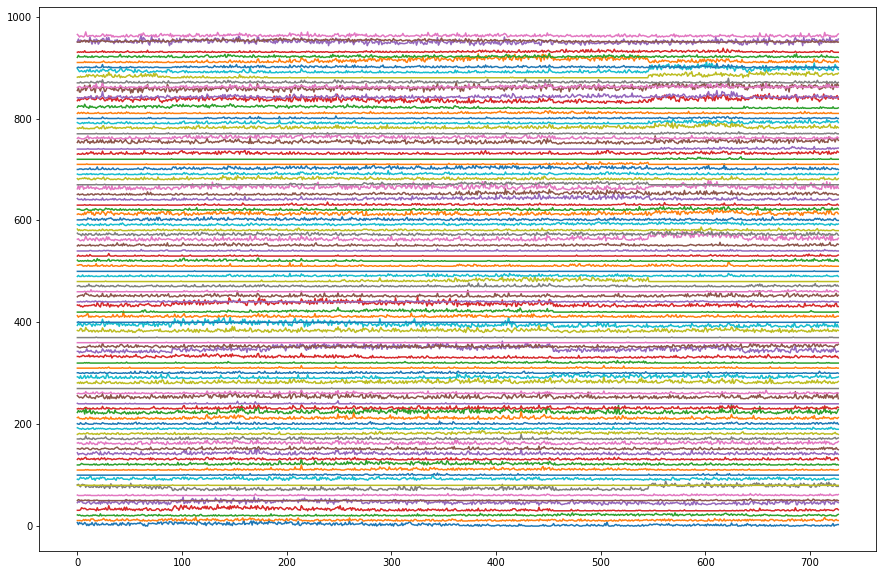

In [7]:
# Plot the raw data here
fig,ax = plt.subplots(figsize=(15,10))
delt = 0

for neuron in np.arange(numChannels):
    plt.plot(spike_data[:,neuron]+delt)
    delt = delt+10  
    
plt.show()

We can also plot the data as an image. Depending on the data it might be easier to idenntify patterns in this display. 

In [8]:
# plot the data as an image
plot_data_as_image(spike_data)

NameError: name 'plot_data_as_image' is not defined

In both plots it is hard to determine whether the spike counts ccorrespond to a change in the angle over trials.

Here we will use PCA to reduce the dimensioanlity of the trials.

In [ ]:
score, evectors, evals = pca(spike_data)

Next we want to plot our trials in the PCA coordinates, also called scores.

As noted above, *Each row of the dataset (728) is a different trial for a different angle of reaching (8 angles total). Trials 1-91 are for reach angle 1, 92-182 for reach angle 2, etc.* In the previous tutorial of cell features, we colored our final PCA plot by whether the cell was excitatory or inhibitory, and using the kmeans labels. Here, we want to color each point on our PCA plot by the reach angle.

To do so, create a vector of "angles", which contains a list of angle names (can simply be 0, 1, 2, 3, etc.) 


In [ ]:
n_trials = 728
angles = np.zeros(n_trials)
angle_start = np.arange(0,n_trials,91)
angle_end = np.arange(91,n_trials,91)

for i in np.arange(len(angle_end)):
    angles[angle_start[i]:angle_end[i]] = i
    

In [ ]:
plot_pca_labels(score,angles)

Note that in the previous tutorial our data had a clustered strucutre. Here the PCs reveal more of a continuum corresponding to the angle.  
We can see this information on angles also appears (to lesser extent) in "deeper" PCs. 

In [ ]:
################################################
## TO DO for students: plot the total variance explained
# Comment once you've filled in the function
raise NotImplementedError("Student excercise: plotting PCs 3-4!")

# Plot prinicipal components 3 and 4


## Part 2: Reconstruct data with different numbers of PCs

Now we have seen that the top 40 or so principal components of the data can explain most of the variance. We can use this fact to perform *dimensionality reduction*, i.e., by storing the data using only 40 components rather than the samples of all the neurons. Remarkably, we will be able to reconstruct much of the structure of the data using only the top 40 components. To see this, recall that to perform PCA we projected the data $\bf X$ onto the eigenvectors of the covariance matrix:
\begin{equation}
\bf S = X W
\end{equation}
Since $\bf W$ is an orthogonal matrix, ${\bf W}^{-1} = {\bf W}^T$. So by multiplying by ${\bf W}^T$ on each side we can rewrite this equation as  
\begin{equation}
{\bf X = S W}^T.
\end{equation}
This now gives us a way to reconstruct the data matrix from the scores and loadings. To reconstruct the data from a low-dimensional approximation, we just have to truncate these matrices.  Let's call ${\bf S}_{1:K}$ and ${\bf W}_{1:K}$ as keeping only the first $K$ columns of this matrix. Then our reconstruction is:
\begin{equation}
{\bf \hat X = S}_{1:K} ({\bf W}_{1:K})^T.
\end{equation}

Exercise:
Fill in the function below to reconstruct the data using different numbers of principal components.

Steps:

- Fill in the following function to reconstruct the data based on the weights and scores. Don't forget to add the mean!
- Make sure your function works by reconstructing the data with all K=784 components. The two images should look identical.

In [ ]:
def reconstruct_data(score, evectors, X_mean, K):
  """
  Reconstruct the data based on the top K components.
  Args:
    score (numpy array of floats)    : Score matrix
    evectors (numpy array of floats) : Matrix of eigenvectors
    X_mean (numpy array of floats)   : Vector corresponding to data mean
    K (scalar)                       : Number of components to include
  Returns:
    (numpy array of floats)          : Matrix of reconstructed data
  """

  #################################################
  ## TO DO for students: Reconstruct the original data in X_reconstructed
  # Comment once you've filled in the function
  raise NotImplementedError("Student excercise: reconstructing data function!")
  #################################################

  # Reconstruct the data from the score and eigenvectors
  # Don't forget to add the mean!!

  X_reconstructed =  ...

  return X_reconstructed

Let's see how well the data is reconstructed for different number of stored compomnents. Below calculate the reconstruction error for ncreasing number of PCs
\begin{equation}
\text{MSE}= \frac{1}{\text{# trials}}\sum_\text{trial} \Vert {\mathbf{X}[:,\text{trial}] -  \hat{\mathbf{X}}[:,\text{trial}]} \Vert_2^2 = \frac{1}{\text{# trials}} \Vert \bf{X} -  \hat{\bf{X}} \Vert_F^2
\end{equation}
The squared reconstruction error is the average squared reconstruction error of all trials. This can also be calculated in matrix form using the Frobenius norm:   
\begin{equation}
\Vert \textbf{X} \Vert_F^2 = \sum_{i,j} |  \textbf{X}[i,j]|^2
\end{equation}

In [ ]:
rec_errors = []
C_values = np.array([1,2, 5, 10, 20, 30, 50, 60, 70, 80, 90, 100, 120])
for C in C_values:
    # Initialize and fit the model
        
    #################################################
    ## TO DO for students: Reconstruct the spike data 
    # Comment once you've filled in the function
    raise NotImplementedError("Student excercise: reconstructing data!")
    #################################################
    
    spike_data_mean = ...

    reconstructed = ...
    recon_error = np.linalg.norm(reconstructed-spike_data,'fro')**2 / np.shape(spike_data)[1]
    rec_errors.append(recon_error.mean())

# Uncomment to plot the reconstruction errors 
# plt.plot(C_values, rec_errors)
# plt.show()

How does the reconstruction error compare to the variance explained? What trend do you notice in comapring the two?

In [ ]:
################################################
## TO DO for students: plot the total variance explained
# Comment once you've filled in the function
raise NotImplementedError("Student excercise: reconstructing data function!")

var_explained = ...

# Uncomment to plot variance explained
# plot_variance_explained(var_explained)


Now let's see what the reconstructed data looks like and how it differs from the original data

In [ ]:
  #################################################
  ## TO DO for students: Reconstruct the spike data for K number of principal components. try different values of K
  # Comment once you've filled in the function
  # raise NotImplementedError("Student excercise: reconstructing data!")
  #################################################
reconstructed = ...

# Uncomment to plot the reconstructed data and  errors 
# plot_data_as_image(reconstructed) # note negative values
# plot_data_as_image((spike_data-reconstructed))

## Part 3. Perform PCA on Neuropixel data

We consider a subset of data from a study of Steinmetz et al. (2019). In this study, Neuropixels probes were implanted in the brains of mice. Electrical potentials were measured by hundreds of electrodes along the length of each probe. Each electrode's measurements captured local variations in the electric field due to nearby spiking neurons. A spike sorting algorithm was used to infer spike times and cluster spikes according to common origin: a single cluster of sorted spikes is causally attributed to a single neuron.

In particular, a single recording session of spike times and neuron assignments was loaded and assigned to spike_times in the preceding setup.

This dataset includes recordings of neurons as mice perform a decision task.
Mice had the task of turning a wheel to indicate whether they perceived a Gabor stimulus to the left, to the right, or not at all. Neuropixel probes measured spikes across the cortex.  We will only consider trials where the mouse chose "Left" or "Right" and ignore NoGo trials.

In the hidden `Data retrieval and loading` cell, there is a function that loads the data:

- `spikes`: an array of normalized spike rates with shape `(n_trials, n_neurons)`
- `choices`: a vector of 0s and 1s, indicating the animal's behavioral response, with length `n_trials`.

In [ ]:
# load the data
data = load_steinmetz_data()
for key, val in data.items():
  print(key, val.shape)

y = data["choices"]
X = data["spikes"] # trials x neurons

In [ ]:
# Plot the spiking rate data here
plot_data_as_image(X) 


### 3.1 Perform PCA on trials

We will first reduce dimensionality of the trials. 
Apply PCA to the *spikes* using the helper functions, and then the first two PCs.


In [ ]:
  #################################################
  ## TO DO for students: calculate PCA
  # Comment once you've filled in the function
  raise NotImplementedError("Student excercise: apply PCA to spike data!")
score, evectors, evals = ...

In [ ]:
# use helper function to plot PCs 
plot_data(score)

We want to see if the choice of the trial is evident in the PCs. We can also see from PC 2 that it has a decreasing trend over trial index.
Color first two PCs by trial index and choice using *plot_pca_labels* helper function


In [ ]:
# color PC using choice in the trials
plot_pca_labels(score,labels = y)

In [ ]:
  #################################################
  ## TO DO for students: color points by trial index
  # Comment once you've filled in the function
  raise NotImplementedError("Student excercise: color PCA by trial index!")

# color PC using trial index
trial_index = ...

# uncomment to plot PCA
# plot_pca_labels(score,labels = trial_index)

Plot next two PCs

In [ ]:
plot_pca_labels(score[:,2:],y)
plot_pca_labels(score[:,2:],trial_index)

We see that both the trial index and the trial choice are apparent in the first few PCs. Can we use this low-dim representation to predict the choice?

### 3.2 Logistic regression and model validation

We learned about logistic regression in the Machine learning tutorial yesterday. A common use of dimensionality reduction is to obtain a new representation of the data in an unsupervised manner, and tehn apply a machine learning method (such as classification) to this new representation. 

Here we will apply logistic regression to the new PCA coordinates and see if there is an "optimal" dimension of the data that reflects the choice. 

In [ ]:
def model_selection(X, y, score, C_values):
  """Compute CV accuracy for each C value.
  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    C_values (1D array): Array of hyperparameter values.
  Returns:
    accuracies (1D array): CV accuracy with each value of C.
  """
  accuracies = []
  for C in C_values:
    
  #################################################
  ## TO DO for students: limit the number of prinicipal components used in the model 
  # Comment once you've filled in the function
  raise NotImplementedError("logistic regression on PCA")
    proj_data = score[:,:C]  ####

    model = LogisticRegression(penalty="none", max_iter=1000)

    # Get the accuracy for each test split
    accs = cross_val_score(model, proj_data, y, cv=8)

    # Store the average test accuracy for this value of C
    accuracies.append(accs.mean())

  return accuracies

# set C values
C_values = np.array([1, 2, 3, 5, 7, 10, 20, 30, 50, 75, 100, 125, 150])

accuracies = model_selection(X, y, score, C_values)
# uncomment to plot accuracy 
# plot_model_selection(C_values, accuracies)

Look at variance explained plot. How does it correspond to the model selection? Compare the number of PCs necessary to recover 90% of the total variance to the number of PCs that result in best classification.

In [ ]:
variance_explained = get_variance_explained(evals)
plot_variance_explained(variance_explained[:150])

### 3.3 Perform PCA on the neurons
Run PCA on other dimension of the data (reducing dimension of the neurons) and plot variance explained. Is the same number of dimensions used to explain 90% of the variance in the data? Why is there a difference? 

In [ ]:
#################################################
  ## TO DO for students: apply PCA to neurons 
  # Comment once you've filled in the function
  raise NotImplementedError("PCA on neurons")
    
Xs =   ...      # neurons x trials

score, evectors, evals = pca(Xs)

# uncomment to plot variance explained
# variance_explained = get_variance_explained(evals)
# plot_variance_explained(variance_explained)

In [ ]:
plot_data(score[:,:2])

In [ ]:
# plot PCs colored by mean value of spike rates
plot_pca_labels(score,np.mean(Xs,1))

# Supplementary videos: Neuromatch tutorial videos

In [ ]:
# @title Video 2: Data Reconstruction
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="ZCUhW26AdBQ", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video